# Time Series Analysis with Long Short-Term Memory Neural Networks

In this notebook, we're going to utilize LSTM neural networks to help with time series forecasting.  While LSTMs were primarily used in Natural Language Processing and Speech Recognition, because they rely on past information to contextualize current information.  This is similar to how Time Series Analysis uses the values of the past to predict current and future values.  This similarity is the reason that LSTMs have become more popular in Time Series modeling and forecasting. 

We're going to measure how accurately our model can predict data that is a week out.

Before we get modeling, however, our data needs to be in a certain format before we feed it into our network.  Time for some more preprocessing!

# Preprocessing

In [1]:
# Importing libraries and dataset

import warnings
warnings.filterwarnings('ignore')

import os
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [3]:
df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Check out the dataset
print(f'Test dates: {df.date.min()} to {df.date.max()}')

# Set to index
df = df.set_index('date')
df = df.asfreq('D')

df.head()

,AK_positiveIncrease,AL_positiveIncrease,AR_positiveIncrease,AS_positiveIncrease,AZ_positiveIncrease,CA_positiveIncrease,CO_positiveIncrease,CT_positiveIncrease,DC_positiveIncrease,DE_positiveIncrease,...,TN_positiveIncrease,TX_positiveIncrease,UT_positiveIncrease,VA_positiveIncrease,VI_positiveIncrease,VT_positiveIncrease,WA_positiveIncrease,WI_positiveIncrease,WV_positiveIncrease,WY_positiveIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


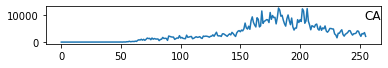

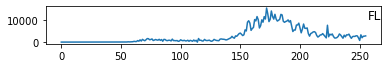

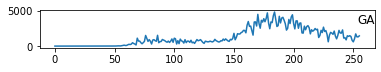

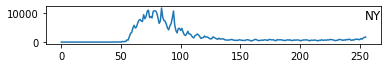

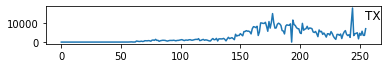

In [10]:
top_5 = df[['CA_positiveIncrease', 'FL_positiveIncrease', 
            'GA_positiveIncrease', 'NY_positiveIncrease', 
            'TX_positiveIncrease']]

# Rename columns for ease of use
top_5 = top_5.rename(columns={'CA_positiveIncrease':'CA', 
                              'FL_positiveIncrease':'FL', 
                              'GA_positiveIncrease':'GA', 
                              'NY_positiveIncrease':'NY', 
                              'TX_positiveIncrease':'TX'})
# Plotting
groups = range(len(top_5.columns))
values = top_5.values
col = 1
#fig = plt.figure(figsize=(20, 10))
for group in groups:
    plt.subplot(len(groups), 1, col)
    plt.plot(values[:, group])
    plt.title(top_5.columns[group], y=0.5, loc='right')
    col += 1
    plt.show();

## Train, Validation, and Test Splits

We're going to split up that sets so that the validation has 14 days, and the test set has 7 days.  This should be a good split considering that the seasonality of the timeseries seems to be weekly across the board.

### Scaling Data

A single LSTM layer will utilize a "forget gate", an "input gate", and an "output gate". Each of these gates use sigmoid function in one way or another.  Because of this, we're going to want to put our data on a scale of 0 to 1. 

Our next steps, then, are to change our values to floats and normalize the data before we split the data up.

In [30]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 14)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test




In [29]:
ca_train, ca_val, ca_test = preprocess_data(df, 'CA_positiveIncrease')

print(f"Train has {len(ca_train)} values")
print(f"Validation has {len(ca_val)} values")
print(f"Test has {len(ca_test)} values")

Train has 235 values
Validation has 14 values
Test has 7 values


Now that we have a function to efficiently split our data, let's make another function that will divide each of our sets into a arrays of `X` and `y` values.

In [14]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Recreate and scale datasets

# California
ca_train = df_train['CA_positiveIncrease'].values.astype('float32')
ca_val= df_val[['CA_positiveIncrease']].values.astype('float32')
ca_test = df_test[['CA_positiveIncrease']].values.astype('float32')

# Florida
fl_train = df_train[['FL_positiveIncrease']].values.astype('float32')
fl_val = df_val[['FL_positiveIncrease']].values.astype('float32')
fl_test = df_test[['FL_positiveIncrease']].values.astype('float32')

# Georgia
ga_train = df_train[['GA_positiveIncrease']].values.astype('float32')
ga_val = df_val[['GA_positiveIncrease']].values.astype('float32')
ga_test = df_test[['GA_positiveIncrease']].values.astype('float32')

# New York
ny_train = df_train['NY_positiveIncrease'].values.astype('float32')
ny_val = df_val[['NY_positiveIncrease']].values.astype('float32')
ny_test = df_test[['NY_positiveIncrease']].values.astype('float32')

# Texas
tx_train = df_train[['TX_positiveIncrease']].values.astype('float32')
tx_val = df_val[['TX_positiveIncrease']].values.astype('float32')
tx_test = df_test[['TX_positiveIncrease']].values.astype('float32')

In [15]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape and normalize datasets

# California
ca_train = scaler.fit_transform(np.reshape(ca_train, (-1, 1)))
ca_val= scaler.fit_transform(np.reshape(ca_val, (-1, 1)))
ca_test = scaler.fit_transform(np.reshape(ca_test, (-1, 1)))

# Florida
fl_train = scaler.fit_transform(np.reshape(fl_train, (-1, 1)))
fl_val = scaler.fit_transform(np.reshape(fl_val, (-1, 1)))
fl_test = scaler.fit_transform(np.reshape(fl_test, (-1, 1)))

# Georgia
ga_train = scaler.fit_transform(np.reshape(ga_train, (-1, 1)))
ga_val = scaler.fit_transform(np.reshape(ga_val, (-1, 1)))
ga_test = scaler.fit_transform(np.reshape(ga_test, (-1, 1)))

# New York
ny_train = scaler.fit_transform(np.reshape(ny_train, (-1, 1)))
ny_val = scaler.fit_transform(np.reshape(ny_val, (-1, 1)))
ny_test = scaler.fit_transform(np.reshape(ny_test, (-1, 1)))

# Texas
tx_train = scaler.fit_transform(np.reshape(tx_train, (-1, 1)))
tx_val = scaler.fit_transform(np.reshape(tx_val, (-1, 1)))
tx_test = scaler.fit_transform(np.reshape(tx_test, (-1, 1)))

In [16]:
ca_test

array([[1.        ],
       [0.41631799],
       [0.00156904],
       [0.54445607],
       [0.47228033],
       [0.74843096],
       [0.        ]])

### Convert from Time Series to Supervised Task
Our next step is to 

array([[0.        , 0.        , 0.20366599, ..., 0.        , 0.        ,
        0.04545455],
       [0.        , 0.        , 0.20366599, ..., 0.        , 0.        ,
        0.04545455],
       [0.        , 0.        , 0.20366599, ..., 0.        , 0.        ,
        0.04545455],
       ...,
       [0.32917706, 0.35391924, 0.77596741, ..., 0.98231827, 0.50720461,
        0.8125    ],
       [0.319202  , 0.32371904, 0.69144603, ..., 0.92501637, 0.81556196,
        0.78977273],
       [0.36658354, 0.57074992, 0.58350305, ..., 1.        , 0.46397695,
        0.90340909]])

### Splitting Sets into Folders
Now that we have the data split into sets, we're going to split these sets into separate folders. These folders will contain pandas dataframes of the original values, as well as the values for the lags time frame we want to consider when predicting our target number of days in the future.  This way we can meet the shape requirements for the neural network.  We'll also be able to make modeling more efficient by having the model look through the data 1 row at a time, as opposed to the whole dataset.  

